# Financial News Sentiment Analysis Project
## Part 1: Data Loading & Exploratory Data Analysis (EDA)

This notebook performs:
1. Import necessary libraries
2. Load multiple financial news data sources
3. Conduct data exploration and statistical analysis
4. Visualize data distribution

## 1. Import Libraries

In [53]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Configure project paths
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load Data Sources

In [54]:
from data_loader import DataLoader

# Locate datasets directory
parent_dir = project_root.parent
if os.path.exists(str(project_root / 'datasets')):
    datasets_path = str(project_root / 'datasets')
else:
    datasets_path = str(parent_dir / 'datasets')

# Load all datasets
loader = DataLoader(datasets_path)
datasets = loader.load_all_datasets()

print(f"✓ Loaded {len(datasets)} data sources")
for name, df in datasets.items():
    print(f"  - {name}: {len(df)} records")

✓ Loaded CFSC-ABSA: 41496 records
✓ Loaded Twitter Financial: 11931 records
✓ Loaded Financial Events: 3024 records
✓ Loaded 3 data sources
  - cfsc_absa: 41496 records
  - twitter: 11931 records
  - financial_events: 3024 records


In [55]:
# Inspect each dataset
for name, df in datasets.items():
    print(f"\n{'='*60}")
    print(f"Dataset: {name} ({len(df)} rows)")
    print(f"{'='*60}")
    print(f"Columns: {list(df.columns)}")
    print(f"Sample:\n{df.head(1)}")
    print(f"Missing values: {df.isnull().sum().sum()}")


Dataset: cfsc_absa (41496 rows)
Columns: ['text', 'aspect', 'sentiment', 'domain', 'source', 'language']
Sample:
                                                text aspect sentiment  \
0  2020年1－10月，中部地区实现利润10341亿元，同比下降4.8%，去年同期为增长5.7...     湖南  positive   

    domain     source language  
0  Economy  CFSC-ABSA  Chinese  
Missing values: 0

Dataset: twitter (11931 rows)
Columns: ['text', 'label', 'dataset', 'sentiment_name', 'source', 'language']
Sample:
                                                text  label dataset  \
0  $BYND - JPMorgan reels in expectations on Beyo...      0   train   

  sentiment_name             source language  
0        Bearish  Twitter Financial  English  
Missing values: 0

Dataset: financial_events (3024 rows)
Columns: ['Date', 'Headline', 'Source', 'Market_Event', 'Market_Index', 'Index_Change_Percent', 'Trading_Volume', 'Sentiment', 'Sector', 'Impact_Level', 'Related_Company', 'News_Url', 'text', 'sentiment', 'source', 'language']
Sample:
         

## 3. Data Preprocessing

In [56]:
from preprocessor import TextPreprocessor, SentimentNormalizer

# Merge all datasets
merged_df = loader.merge_datasets(datasets)

# Normalize sentiment labels
merged_df['sentiment_normalized'] = merged_df['sentiment'].apply(SentimentNormalizer.normalize)

# Add text statistics
merged_df['text_length'] = merged_df['text'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
merged_df['word_count'] = merged_df['text'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

print(f"✓ Merged dataset: {len(merged_df)} samples")
print(f"Sentiment distribution:\n{merged_df['sentiment_normalized'].value_counts()}")

✓ Merged dataset: 56141 samples
Sentiment distribution:
sentiment_normalized
positive    28799
neutral     13910
negative    13432
Name: count, dtype: int64


In [57]:
import nltk

# Download required NLTK packages
nltk_packages = ['punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']
for package in nltk_packages:
    try:
        nltk.download(package, quiet=True)
    except:
        pass

# Preprocess English data
en_mask = merged_df['language'] == 'English'
en_data = merged_df[en_mask].copy()

if len(en_data) > 0:
    preprocessor_en = TextPreprocessor('english')
    en_data['text_processed'] = en_data['text'].apply(
        lambda x: preprocessor_en.preprocess(x, tokenize=False) if pd.notna(x) else ''
    )

# Preprocess Chinese data
zh_mask = merged_df['language'] == 'Chinese'
zh_data = merged_df[zh_mask].copy()

if len(zh_data) > 0:
    preprocessor_zh = TextPreprocessor('chinese')
    zh_data['text_processed'] = zh_data['text'].apply(
        lambda x: preprocessor_zh.preprocess(x, tokenize=False) if pd.notna(x) else ''
    )

print(f"✓ Preprocessing completed: EN={len(en_data)}, ZH={len(zh_data)}")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xuzijian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xuzijian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\xuzijian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✓ Preprocessing completed: EN=14645, ZH=41496


In [58]:
import nltk

# Download required NLTK packages
nltk_packages = ['punkt_tab', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']
for package in nltk_packages:
    try:
        nltk.download(package, quiet=True)
    except:
        pass

print("✓ NLTK packages ready")

✓ NLTK packages ready


## 4. Exploratory Data Analysis (EDA)

In [59]:
# Basic statistics
print(f"Total samples: {len(merged_df)}")
print(f"English: {en_mask.sum()} ({en_mask.sum()/len(merged_df)*100:.1f}%)")
print(f"Chinese: {zh_mask.sum()} ({zh_mask.sum()/len(merged_df)*100:.1f}%)")
print(f"\nSentiment distribution:")
print(merged_df['sentiment_normalized'].value_counts())
print(f"\nText statistics:")
print(f"Length - Mean: {merged_df['text_length'].mean():.0f}, Std: {merged_df['text_length'].std():.0f}")
print(f"Words - Mean: {merged_df['word_count'].mean():.0f}, Std: {merged_df['word_count'].std():.0f}")

Total samples: 56141
English: 14645 (26.1%)
Chinese: 41496 (73.9%)

Sentiment distribution:
sentiment_normalized
positive    28799
neutral     13910
negative    13432
Name: count, dtype: int64

Text statistics:
Length - Mean: 117, Std: 90
Words - Mean: 4, Std: 5


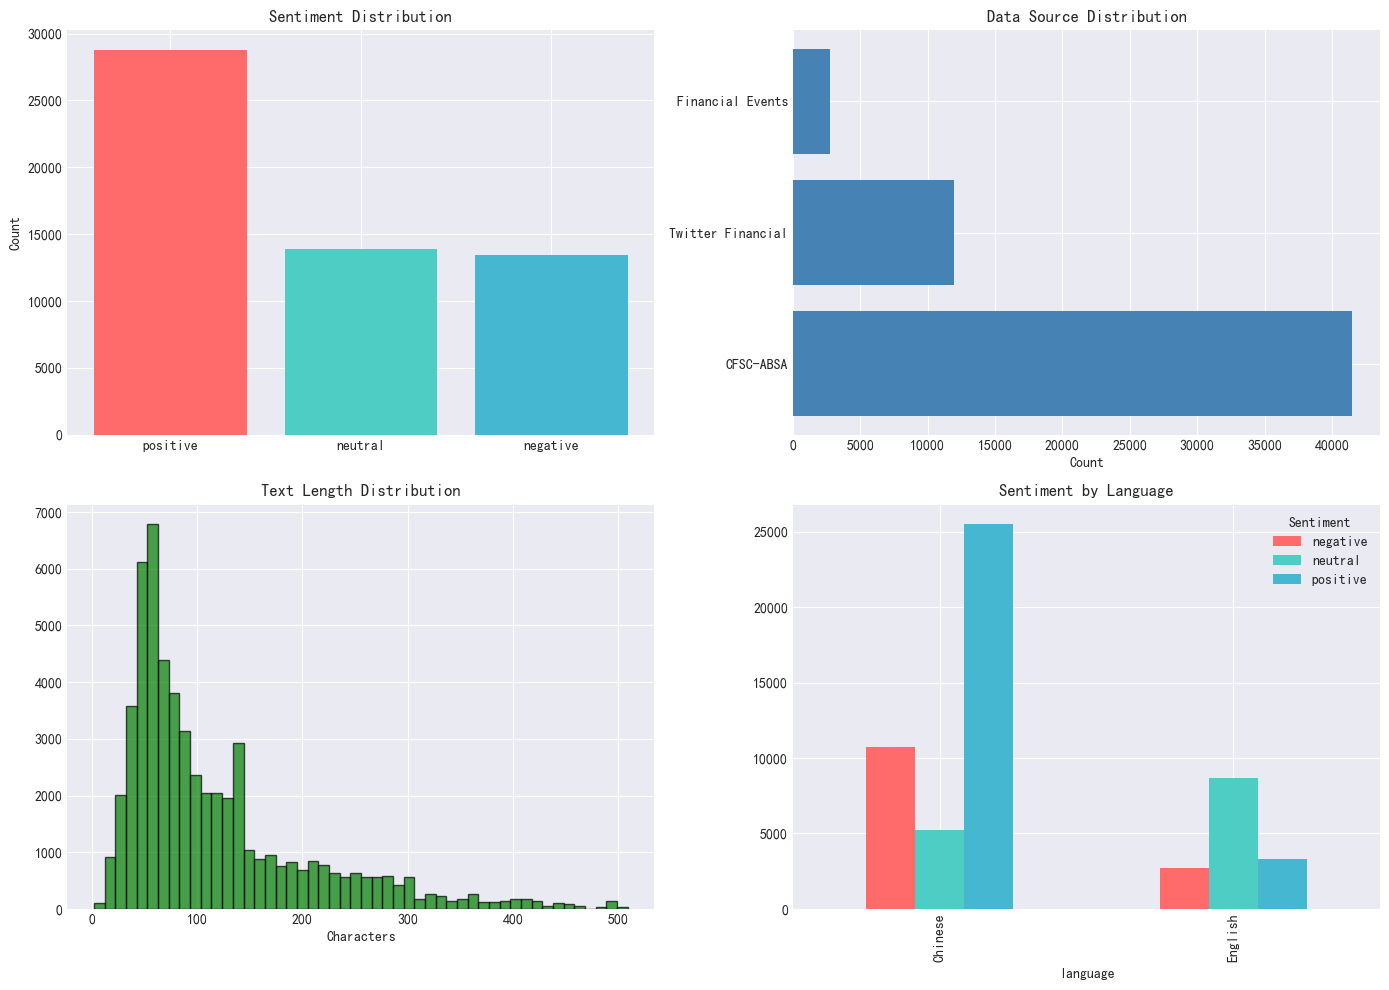

✓ Visualizations completed


In [60]:
# Visualizations: Sentiment & Source Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sentiment distribution
sentiment_counts = merged_df['sentiment_normalized'].value_counts()
axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Sentiment Distribution', fontweight='bold')
axes[0, 0].set_ylabel('Count')

# Data source distribution
source_counts = merged_df['source'].value_counts()
axes[0, 1].barh(source_counts.index, source_counts.values, color='steelblue')
axes[0, 1].set_title('Data Source Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Count')

# Text length distribution
axes[1, 0].hist(merged_df['text_length'], bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Text Length Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Characters')

# Sentiment by language
lang_sentiment = pd.crosstab(merged_df['language'], merged_df['sentiment_normalized'])
lang_sentiment.plot(kind='bar', ax=axes[1, 1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('Sentiment by Language', fontweight='bold')
axes[1, 1].legend(title='Sentiment')

plt.tight_layout()
plt.show()
print("✓ Visualizations completed")

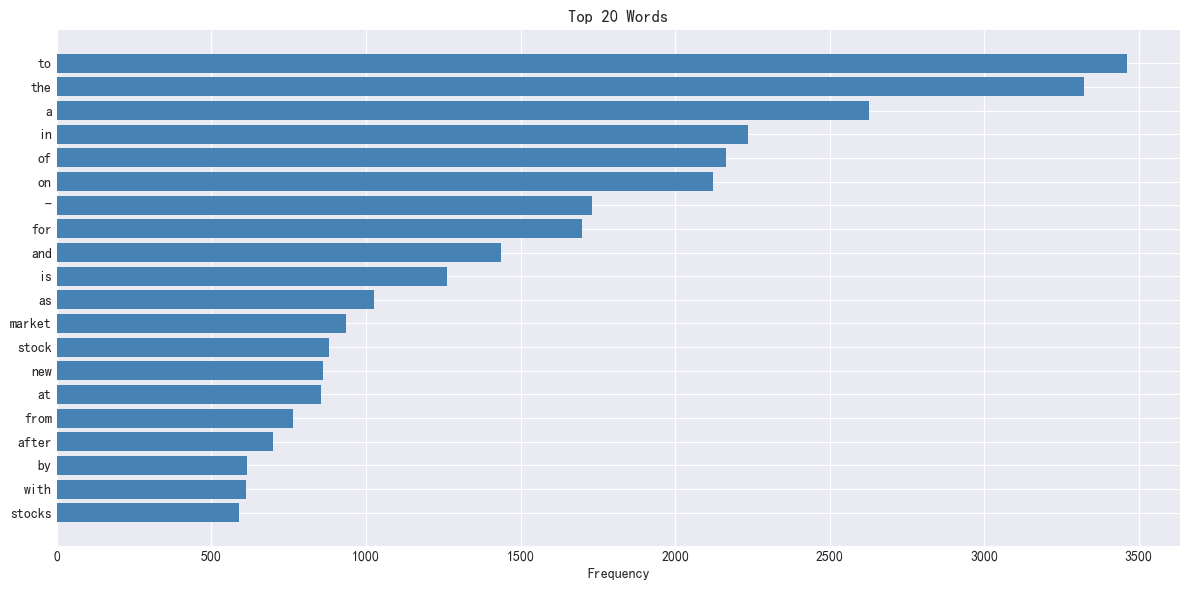

✓ Corpus: 167535 total words, 32816 unique


In [61]:
# Word frequency analysis
if len(en_data) > 0:
    all_words = []
    for text in en_data['text'].dropna():
        words = str(text).lower().split()
        all_words.extend(words)
    
    word_freq = Counter(all_words)
    top_20 = word_freq.most_common(20)
    words, freqs = zip(*top_20)
    
    plt.figure(figsize=(12, 6))
    plt.barh(list(words), list(freqs), color='steelblue')
    plt.xlabel('Frequency')
    plt.title('Top 20 Words', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Corpus: {len(all_words)} total words, {len(word_freq)} unique")

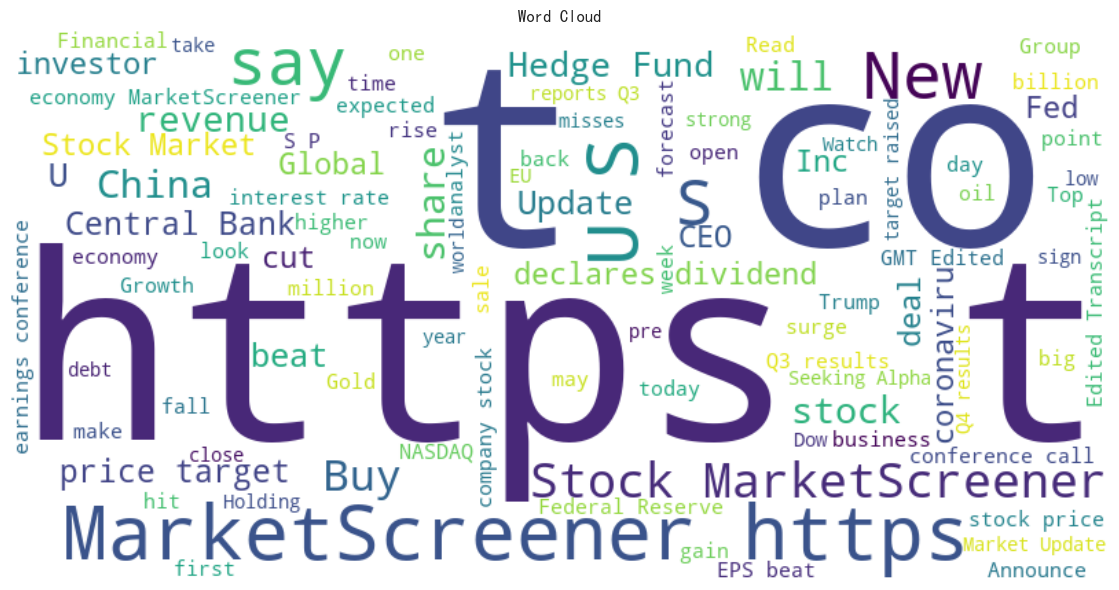

In [62]:
# Word cloud
if len(en_data) > 0:
    text_all = ' '.join(en_data['text'].dropna().astype(str).values)
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap='viridis', max_words=100).generate(text_all)
    
    plt.figure(figsize=(14, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud', fontweight='bold')
    plt.tight_layout()
    plt.show()

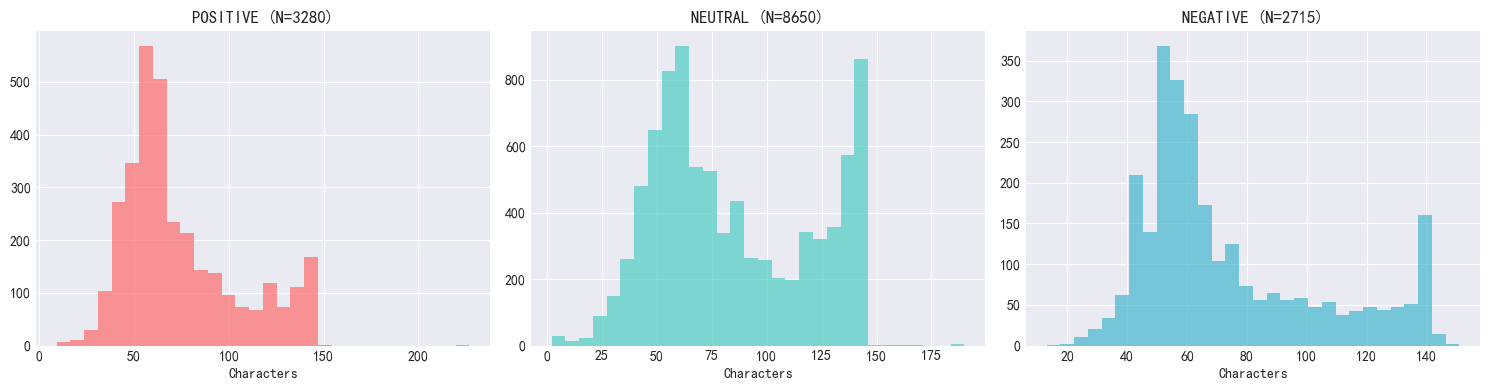

In [63]:
# Text length by sentiment
if len(en_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sentiments = ['positive', 'neutral', 'negative']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
        data_subset = en_data[en_data['sentiment_normalized'] == sentiment]
        if len(data_subset) > 0:
            axes[idx].hist(data_subset['text_length'], bins=30, color=color, alpha=0.7)
            axes[idx].set_title(f'{sentiment.upper()} (N={len(data_subset)})', fontweight='bold')
            axes[idx].set_xlabel('Characters')
    
    plt.tight_layout()
    plt.show()

In [64]:
# Data quality check
print("\n=== Data Quality Check ===")
print(f"Missing values: {merged_df[['text', 'sentiment']].isnull().sum().sum()}")
print(f"Empty texts: {(merged_df['text'].astype(str).str.strip() == '').sum()}")
print(f"Duplicates: {merged_df.duplicated(subset=['text', 'sentiment']).sum()}")


=== Data Quality Check ===
Missing values: 0
Empty texts: 0
Duplicates: 26634


In [65]:
# Save cleaned data
cleaned_df = merged_df[
    (merged_df['text'].notna()) & 
    (merged_df['text'].astype(str).str.strip() != '') &
    (merged_df['sentiment_normalized'].notna())
].drop_duplicates(subset=['text', 'sentiment_normalized'], keep='first')

cleaned_df.to_csv('../data/processed/merged_cleaned.csv', index=False, encoding='utf-8')

print(f"\n=== Data Cleaning Summary ===")
print(f"Before: {len(merged_df)}, After: {len(cleaned_df)}, Removed: {len(merged_df) - len(cleaned_df)}")
print(f"✓ Cleaned data saved to data/processed/merged_cleaned.csv")


=== Data Cleaning Summary ===
Before: 56141, After: 29507, Removed: 26634
✓ Cleaned data saved to data/processed/merged_cleaned.csv


In [66]:
# Summary
print("\n" + "="*60)
print("EDA COMPLETE")
print("="*60)
print(f"✓ Loaded: {len(datasets)} sources")
print(f"✓ Total: {len(cleaned_df)} samples")
print(f"✓ English: {(cleaned_df['language']=='English').sum()}")
print(f"✓ Chinese: {(cleaned_df['language']=='Chinese').sum()}")
print(f"✓ Positive: {(cleaned_df['sentiment_normalized']=='positive').sum()}")
print(f"✓ Neutral: {(cleaned_df['sentiment_normalized']=='neutral').sum()}")
print(f"✓ Negative: {(cleaned_df['sentiment_normalized']=='negative').sum()}")


EDA COMPLETE
✓ Loaded: 3 sources
✓ Total: 29507 samples
✓ English: 12081
✓ Chinese: 17426
✓ Positive: 11670
✓ Neutral: 11067
✓ Negative: 6770
